In [1]:
# %matplotlib ipympl

In [2]:
import torch
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from time import sleep, time
import sys
import os
DatasetPath = '../Dataset/' 
# append absolute DasetPath to path
DatasetPath = os.path.abspath(DatasetPath)
sys.path.append(DatasetPath)
import Dataset2 as DS

import pandas as pd

importlib.reload(DS)
DatasetContainer = DS.DatasetContainer
ProcessingDatasetContainer = DS.ProcessingDatasetContainer

def PLTParams(figsize = [10,10]):
    plt.rcParams['figure.figsize']=figsize
    plt.rcParams['font.size']=15
PLTParams()



sys.path.append(os.path.abspath('../CherenkovFraction/'))

# Add the ignore warnings
import warnings
warnings.filterwarnings("ignore")

hostname = os.uname()
if 'tedtop' in hostname: plt.style.use('/home/fedor-tairli/work/MPLStylefiles/Vscode_DarkModern_Invisible.mplstyle')

plt.style.use('default')


In [3]:
def IndexToXY(indices,return_tensor=False):
    indices = indices -1
    Xs = indices//22
    Ys = indices%22
    if return_tensor: return Xs.int(),Ys.int()
    else:             return Xs.int().tolist(),Ys.int().tolist()



#### Import Datasets

In [4]:
DataPath = os.path.abspath('../Data/Processed/')
print('DataPath:',DataPath)

DataPath: /remote/tychodata/ftairli/work/CDEs/Data/Processed


In [5]:
# Importing Dataset
# Cause it takes a while to lad this thing introduce a check if its already laoded into globals
CheckGlobals = True 
LoadTraces = True

if CheckGlobals: 
    if 'Dataset' in globals():
        print('Dataset already loaded')
        if len(Dataset.Event_level_keys.keys())<1: # pyright: ignore[reportUndefinedVariable]
            print('Dataset Event_level_keys is None, reloading Dataset')
            Dataset.Load(DataPath,'CDEsDataset' ,LoadTraces=LoadTraces) # pyright: ignore[reportUndefinedVariable]
    else:
        print('Loading Dataset')
        Dataset = DatasetContainer()
        Dataset.Load(DataPath,'CDEsDataset' ,LoadTraces=LoadTraces)

# Unfuck the Dataset Keys, cuase the EventID string should have a capital D....
if 'EventId_1/2' in Dataset.Event_level_keys.keys(): # pyright: ignore[reportPossiblyUnboundVariable]
    Dataset.Event_level_keys['EventID_1/2'] = Dataset.Event_level_keys.pop('EventId_1/2') # type: ignore
    Dataset.Event_level_keys['EventID_2/2'] = Dataset.Event_level_keys.pop('EventId_2/2') # pyright: ignore[reportPossiblyUnboundVariable]
    print('Replaced the EventID Keys, with proper ones')
else:
    print('EventID Keys already replaced')

Loading Dataset
Loading CDEsDataset
EventID Keys already replaced


In [6]:
print('Event level keys:')
for key in Dataset.Event_level_keys.keys(): print('    ',key)
print('Pixel level keys:')
for key in Dataset.Pixel_level_keys.keys(): print('    ',key)

Event level keys:
     EventID_1/2
     EventID_2/2
     Rec_Level
     Event_Class
     Primary
     Gen_LogE
     Gen_CosZenith
     Gen_Xmax
     Gen_dEdXmax
     Gen_SDPPhi
     Gen_SDPTheta
     Gen_Chi0
     Gen_Rp
     Gen_T0
     Gen_CoreEyeDist
     Gen_CherenkovFraction
     Rec_LogE
     Rec_CosZenith
     Rec_Xmax
     Rec_dEdXmax
     Rec_SDPPhi
     Rec_SDPTheta
     Rec_Chi0
     Rec_Rp
     Rec_T0
     Rec_CoreEyeDist
     Rec_CherenkovFraction
Pixel level keys:
     PixelID
     TelID
     EyeID
     Status
     Charge
     Theta
     Phi
     TimeOffset
     PulseStart
     PulseCentroid
     PulseStop


In [7]:
AllPossiblePixelDirections = pd.read_csv('../ReadingData/camera_view_table_with_HEAT_down.txt',sep=' ',header=None,names = ['EyeID','TelID','PixID','Theta','Phi'])

In [8]:
AllPossiblePixelDirections.head()

,EyeID,TelID,PixID,Theta,Phi
0,1,1,1,1.61140,358.419
1,1,1,2,2.86980,359.174
2,1,1,3,4.13764,358.434
3,1,1,4,5.38773,359.205
4,1,1,5,6.66357,358.476


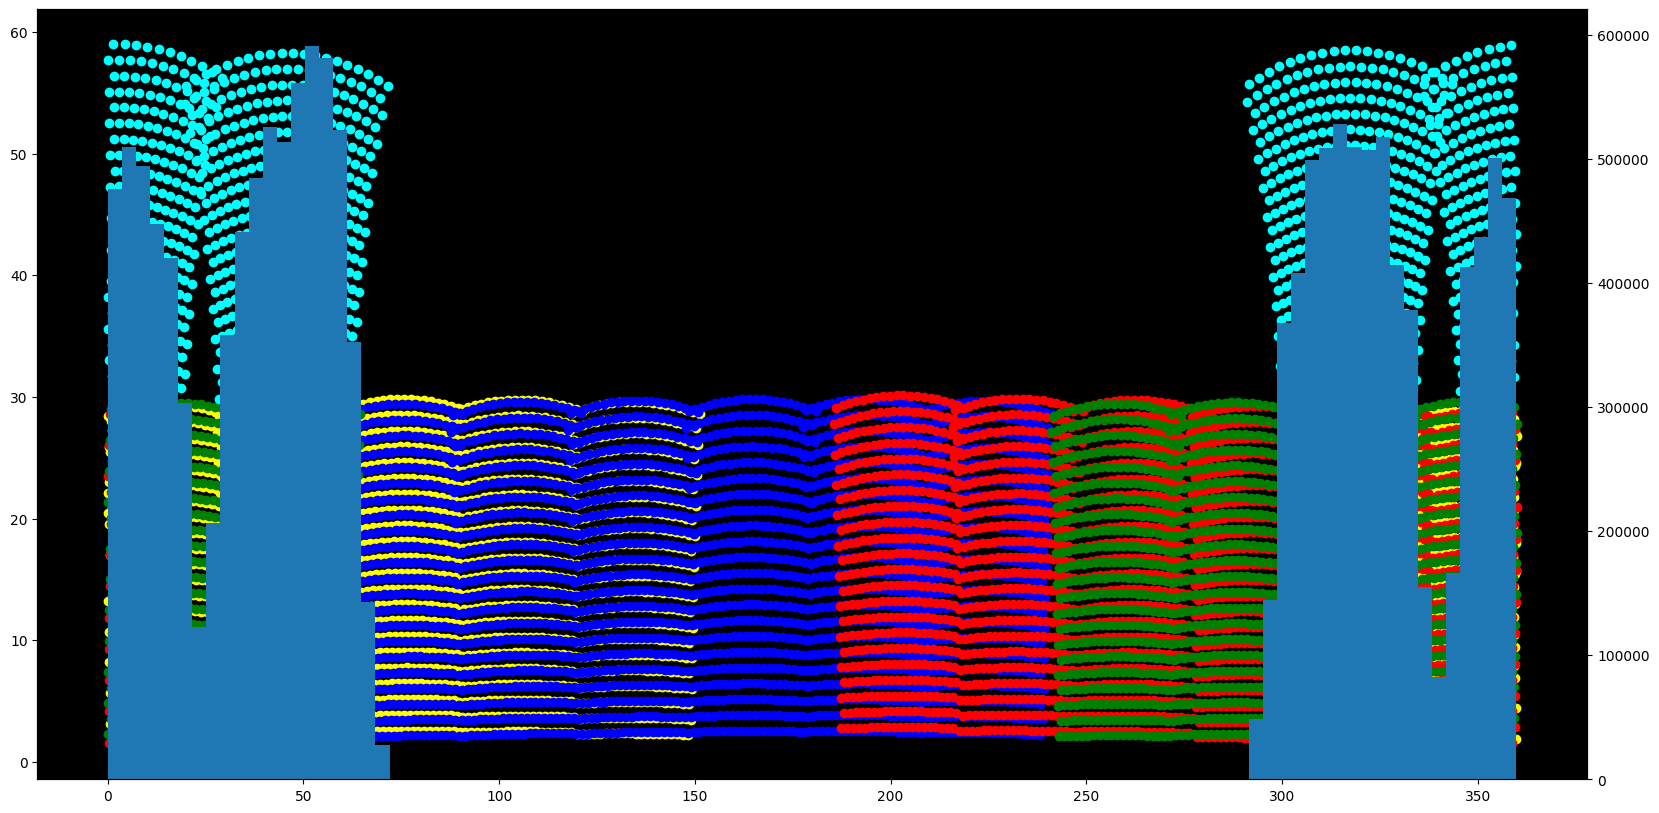

In [9]:
colors = ['yellow','blue','red','green','cyan']
plt.figure(figsize = (20,10))
plt.gca().set_facecolor('black')
for iEye in range(1,6):
    Mask = AllPossiblePixelDirections.EyeID == iEye
    Thetas = AllPossiblePixelDirections.Theta[Mask]
    Phis   = AllPossiblePixelDirections.Phi[Mask]
    plt.scatter(Phis,Thetas,c = colors[iEye-1])
    
ax2 = plt.gca().twinx()
CO_BackwallAngle = 243.0219
HE_BackwallAngle = 273.0
AllThetas = Dataset.get_pixel_values('Theta')
# plt.hist(AllThetas,bins=100)
AllPhis   = Dataset.get_pixel_values('Phi')
X = AllPhis+HE_BackwallAngle
X[X>360] -= 360
ax2.hist(X,bins=100)
plt.show()

In [10]:
event_class_labels = {
    0: 'Shower Candidate',
    1: 'Close Shower',
    2: 'Horizontal Shower',
    3: 'Large Event',
    4: 'Muon + Noise',
    5: 'Long Muon',
    6: 'Noise',
    7: 'Muon'
}

In [12]:
def Get_Pixel_Neighbour_Dict():

    neighbour_dict = {}

    for idx in range(1,441):

        n_l = idx - 22
        n_r = idx + 22
            
        neighbour_same_col_u = idx - 1        
        neighbour_same_col_d = idx + 1

        neighbour_side_col_u = n_l - 1 if idx % 2 == 0 else n_r - 1
        neighbour_side_col_d = n_l + 1 if idx % 2 == 0 else n_r + 1

        neighbor_pixels = []
        
        # Check boundaries and append neighbours
        
        # Left most column
        if idx <23:
            n_l = None
            if idx % 2 == 0:
                neighbour_side_col_u = None
                neighbour_side_col_d = None
        
        # Right most column
        if idx > 418:
            n_r = None
            if idx % 2 == 1:
                neighbour_side_col_u = None
                neighbour_side_col_d = None
            
        # Top row
        if idx % 22 == 1:
            neighbour_same_col_u = None
            neighbour_side_col_u = None
        # Bottom row
        if idx % 22 == 0:
            neighbour_same_col_d = None
            neighbour_side_col_d = None
        
        for n in [n_l, n_r, neighbour_same_col_u, neighbour_same_col_d, neighbour_side_col_u, neighbour_side_col_d]:
            if n is not None:
                neighbor_pixels.append(n)
        

        neighbour_dict[idx] = neighbor_pixels
    return neighbour_dict

In [15]:
N = np.random.randint(0,len(Dataset))

Event = Dataset.get_event_by_index(N)

Neighbour_Dict = Get_Pixel_Neighbour_Dict()

In [30]:
# This_Main = torch.zeros()
for i, Event in enumerate(Dataset):
    NeighbourDict = Get_Pixel_Neighbour_Dict()

    pix_ID = Event.get_pixel_values('PixelID')
    N_pixels = pix_ID.shape[0]

    Traces = Event.get_trace_values()
    Trace_Main = torch.zeros(N_pixels,2100)

    pix_PulseStart = Event.get_pixel_values('PulseStart')
    print(f'PulseStart {pix_PulseStart}')
    indices = (torch.arange(40)+pix_PulseStart.unsqueeze(1)).long()
    print(('indices'))
    print(indices)

    Trace_Main.scatter_(1,indices,Traces)
    print('Trace_Main[0]')
    for idx in range(2100) : print(Trace_Main[0,idx])

    if i == 0:break

PulseStart tensor([ 580.,  580.,  579.,  579.,  579.,  580.,  580.,  581.,  580.,  580.,
         579.,  580.,  579.,  580.,  579.,  579.,  584.,  584.,  589.,  580.,
         583.,  584.,  583.,  589.,  579.,  584.,  363.,  581.,  583.,  583.,
         589.,  583.,  583.,  589.,  583.,  589.,  583.,  587.,  584.,  363.,
         587.,  583.,  589.,  363.,  587.,  589.,  587.,  589.,  589.,  363.,
         363., 1481.,  363., 1481., 1481., 1481.,  363., 1481., 1481., 1481.,
        1481., 1481.])
indices
tensor([[ 580,  581,  582,  ...,  617,  618,  619],
        [ 580,  581,  582,  ...,  617,  618,  619],
        [ 579,  580,  581,  ...,  616,  617,  618],
        ...,
        [1481, 1482, 1483,  ..., 1518, 1519, 1520],
        [1481, 1482, 1483,  ..., 1518, 1519, 1520],
        [1481, 1482, 1483,  ..., 1518, 1519, 1520]])
Trace_Main[0]
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(